In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.gridspec import GridSpec
import pylab
import hickle as hkl


from influencer_games.adaptive_dynamics.visualization import Shell
from influencer_games.utils.utilities import *
from influencer_games.domains.resource_distributions import *

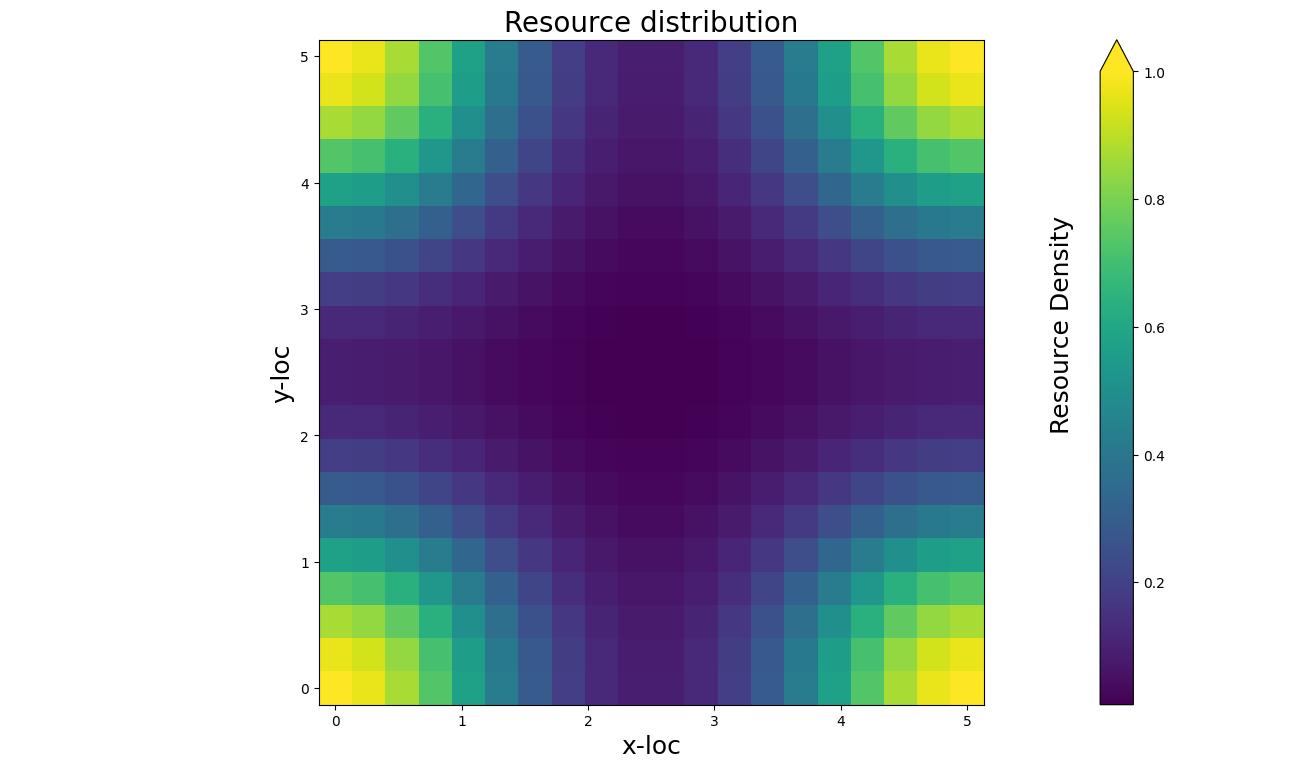

In [2]:
domain_type='2d'
domain_bounds=np.array([[0,5],[0,5]])
font_size_labels=18
font_size_title=20
domain_refinement=20
rect_Y, rect_X = np.mgrid[domain_bounds[0,0]:domain_bounds[0,1]:domain_refinement*1j, domain_bounds[1,0]:domain_bounds[1,1]:domain_refinement*1j]
rect_positions = np.vstack([rect_X.ravel(), rect_Y.ravel()])
rect_positions=rect_positions.transpose()
fig = plt.figure(figsize=(19, 7))
gs = GridSpec(nrows=1, ncols=1,width_ratios=[1],wspace=0.0, hspace=0.2, top=1, bottom=0.05, left=0.17, right=0.845)
ax0 = fig.add_subplot(gs[:, 0])
ax0.set_box_aspect(1)
current_alpha=5
resource_parameters_MVG=[torch.tensor([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1.0]]]),torch.tensor([[0,0],[current_alpha,0],[0, current_alpha],[current_alpha,current_alpha]])]
resource_type='multi_modal_gaussian_distribution_2D_square'

resources=resource_distribution_choice(bin_points=rect_positions,resource_type=resource_type,resource_parameters=resource_parameters_MVG)
pval=resources.reshape(len(rect_Y),len(rect_X))
im = ax0.pcolormesh(rect_X,rect_Y, pval)

# Make the plot square
ax0.set_box_aspect(1) 
plt.title('Resource distribution',fontsize=font_size_title)
plt.xlabel('x-loc',fontsize=font_size_labels)
plt.ylabel('y-loc',fontsize=font_size_labels)

ax1 = fig.add_subplot(gs[:, 0])
cbar=fig.colorbar(im,ax=ax1, extend='max',location='right',ticklocation='left')
ax1.yaxis.set_ticks_position('left')
ax1.set_box_aspect(.1)
ax1.axis('off')

ax2 = fig.add_subplot(gs[:, 0])
ax2.axis('off')
ax2.set_box_aspect(.1)
ax2.set_title('Resource Density',x=.82, y=0, rotation = 90,size=font_size_labels)
# Add a colorbar




fig.savefig('2d_square_alpha_1.svg',bbox_inches='tight')

In [3]:
def custom_infl_2d(x_torch:torch.Tensor,
                   bin_points:np.ndarray,
                   parameter_instance:torch.Tensor,
                   )->torch.Tensor:
    """"
    Takes the agent's postion and parameters finds the agnet's influence using multi-variate gaussian method
    INPUTS:
        agent_id:The current player\agent's id (i)
        agents_pos: current agent postions
        bin_points:locations of the resource/bin points    
        sigma_inv:Covariance matrix inverse (Sigma^-1)
    OUTPUTS:
        infl: The agents influence using MVG method
    """
    infl=[]
    x_vec=(torch.tensor(bin_points)-x_torch).float()
    for i in range(len(bin_points)):
        infl_val=torch.exp(-1/2*x_vec[i,:]@parameter_instance@x_vec.T[:,i])
        infl.append(infl_val)
    # to maintain the autograd we must do torch stack!
    infl=torch.stack(infl)
    return infl


In [4]:
num_agents=4
infl_configs={"infl_type":"custom","custom_influence":custom_infl_2d}
domain_type='2d'
int_agents_pos=player_postion_setup(num_agents=num_agents,setup_type="intial_symmetric_setup",domain_type=domain_type,domain_bounds=domain_bounds)
#int_agents_pos=[[7.5,7.5],[7.5,7.5],[7.5,7.5],[7.5,7.5]] 
parameters=torch.tensor([[[1/3,0],[0,1/3]],[[1/3,0],[0,1/3]],[[1/3,0],[0,1/3]],[[1/3,0],[0,1/3]]])
bin_points=rect_positions
resource_distribution=resources
lr_type='cosine' #static or cosine
learning_rate=[1/50,1/10,250]
time_steps=500

vis=Shell(num_agents=num_agents, agents_pos=int_agents_pos.copy(), parameters=parameters,resource_distribution=resource_distribution,bin_points=bin_points,infl_configs=infl_configs,lr_type=lr_type,learning_rate=learning_rate,time_steps=time_steps,domain_type=domain_type,domain_bounds=domain_bounds,resource_type=resource_type,domain_refinement=domain_refinement,tolarance=.000001)

In [5]:
vis.setup_adaptive_env()
vis.field.gradient_accent()
og_pos_matrix=vis.field.pos_matrix
og_grad_matrix=vis.field.grad_matrix
vis.agents_pos=int_agents_pos.copy()
vis.field.agents_pos=int_agents_pos.copy()

C:\Users\Mark-Fu-Lab\AppData\Local\Temp\ipykernel_42212\177638655.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  infl_val=torch.exp(-1/2*x_vec[i,:]@parameter_instance@x_vec.T[:,i])
C:\Users\Mark-Fu-Lab\AppData\Local\Temp\ipykernel_42212\177638655.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  infl_val=torch.exp(-1/2*x_vec[i,:]@parameter_instance@x_vec.T[:,i])


broke


C:\Users\Mark-Fu-Lab\AppData\Local\Temp\ipykernel_42212\177638655.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  infl_val=torch.exp(-1/2*x_vec[i,:]@parameter_instance@x_vec.T[:,i])


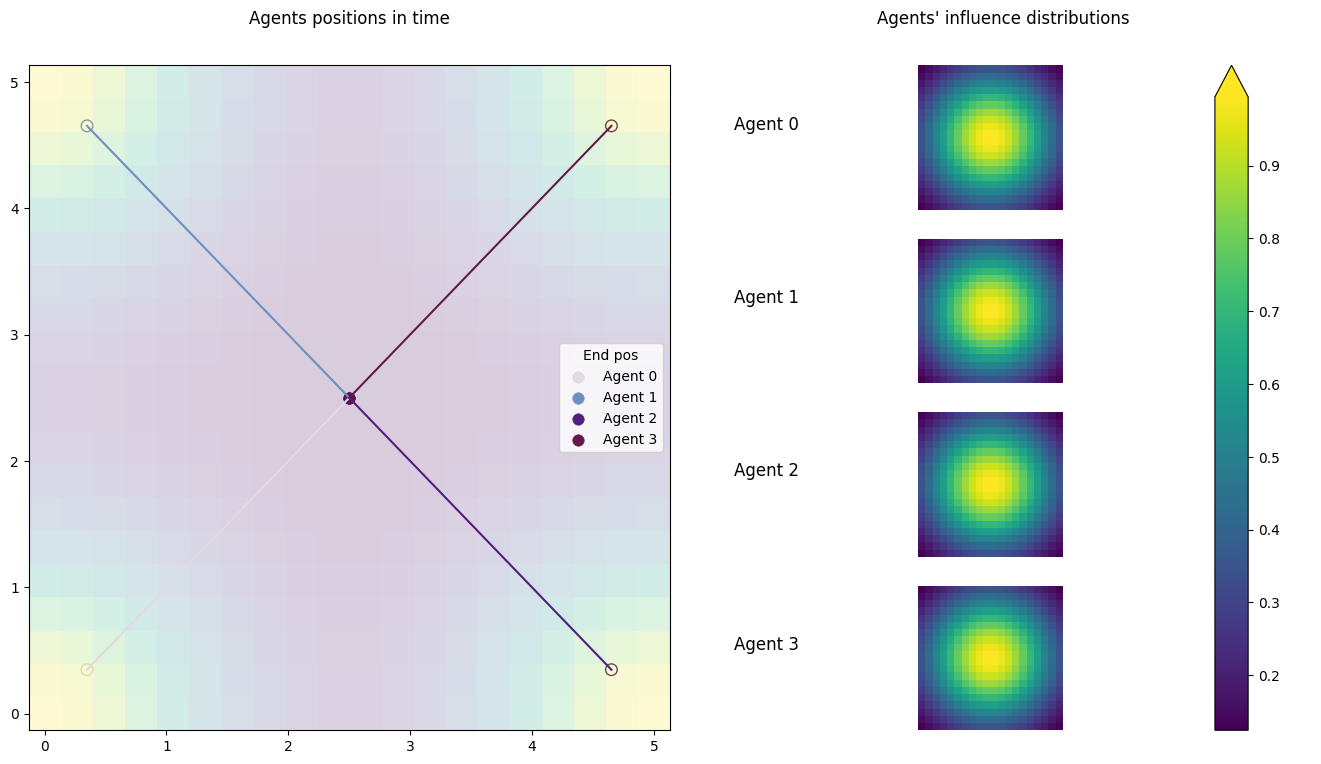

In [6]:
vis.dist_pos_gif(1)